In [1]:
using PyPlot
using GaussianProcesses

srand(42);

## A Motivating Example

Some engineers come to us with a problem. They're trying to figure out the effect of varying some parameter. They have a simulation which allows them to change the parameter and the simulation will provide them a score. The simulation is expensive however, so they want you to estimate the function using only a few (noisy) observations.

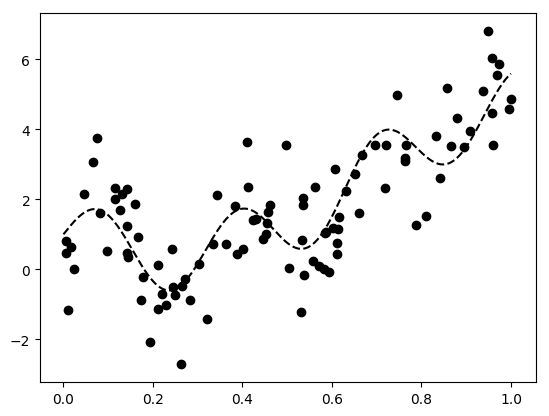

In [2]:
true_f(x) = x^2 - sin(5x) + sin(20x) + exp(x)

grid = collect(linspace(0, 1, 1000))
true_y = true_f.(grid)

nSamples = 100

x_train = collect(rand(nSamples))
y_train = true_f.(x_train) + randn(nSamples)

plot(grid, true_y, color = "black", linestyle = "--")
scatter(x_train, y_train, color = "black");

## Regular Bayesian Linear Regression

Suppose we have the model

$$y = x^{T}w + \epsilon$$

where $\epsilon \sim N(0, \sigma_{n}^{2})$.

This induces a likelihood

$$p(y \mid X, w) = N(X^{T}w, \sigma_{n}^{2}I)$$

Following the Bayesian practice, we put a prior on $w$; 

$$w \sim N(0, \Sigma_{p})$$.

We then derive the posterior

$$p(w \mid X, y) \sim N(\frac{1}{\sigma_{n}^{2}}A^{-1}Xy, A^{-1})$$

where $A = \sigma_{n}^{-2}XX^{T} + \sum_{p}^{-1}$.

and thus the predictive distribution

$$p(y_{*} \mid x_{*}, X, y) = N(\frac{1}{\sigma_{n}^{2}}x_{*}^{T}A^{-1}Xy, x_{*}^{T}A^{-1}x_{*})$$.

As a side note; if you let $\Sigma_{p}$ become diffuse and thus $\Sigma_{p}^{-1} \rightarrow 0$ you recover the usual linear regression estimator.

## The "Weight Space" View of Gaussian Processes

We can extend this like we do linear regression; suppose we project our $x$ into a higher-dimensional space. This is common enough in linear regression where we'll project onto the power basis, Fourier basis, etc. So we're just going to replace $x$ with $\phi(x)$ which is the high-dimensional or maybe even infinite dimensional projection.

Then with similar arguments we get predictive distribution

$$p(y_{*} \mid x_{*}, X, y) = N(\frac{1}{\sigma_{n}^{2}}\phi(x_{*})^{T}A^{-1}\phi(X)y, \phi(x_{*})^{T}A^{-1}\phi(x_{*}))$$

where $A = \sigma_{n}^{-2}\phi(X)\phi(X)^{T} + \sum_{p}^{-1}$.

### The Kernel Trick
Notice that the feature space $\phi(x)$ always appears as inner products. This is nice because it lets use apply the kernel trick. We define $K(x, x') = \phi(x)^{T}\Sigma_{p}\phi(x')$ as the covariance kernel.

This is great because it's often easier to determine the inner product rather than work with the feature representations directly. For instance, if we're projecting onto an infinite feature space we're going to run out of memory rather quickly.

## Moving on to Gaussian Processes

A _Gaussian process_ is a generalization of the Gaussian (Normal) distribution. It has two parameters: a mean function $\mu(x)$ and covariance function $K(x, x')$.

$$f(x) \sim GP(\mu(x), K(x, x'))$$

Any finite sample from the Gaussian process will follow a multivariate-Gaussian distribution with the mean and covariance.

## Plots of draws from a Gaussian Process

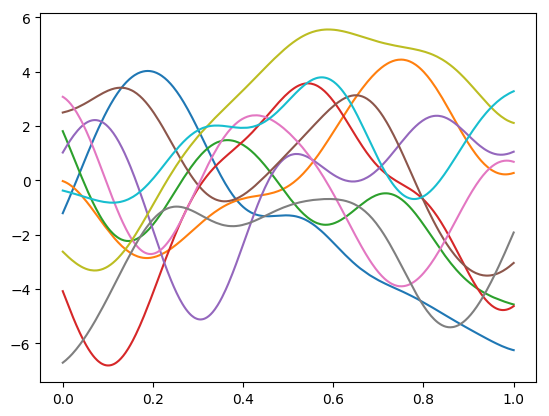

In [3]:
nDraws = 10
nPoints = 100

gp = GP(m = MeanZero(), k = SE(-2.0, 1.0))
prior_draws = rand(gp, grid, nDraws)

plot(grid, prior_draws);

## The "Function Space" View of Gaussian Processes

We can derive Gaussian process regression by conditioning upon the observed data.

In theory, you can draw functions from the prior and reject the ones that don't agree with observations (ABC approach). That will take forever so fortunately there exist easy analytic solutions.

The joint distribution of training data $f$ and test data $f^{*}$ by the prior is

$$
\begin{bmatrix} f \\ f_{*} \end{bmatrix}
\sim
N(0, \begin{bmatrix} K(X, X) & K(X, X_{*}) \\
                     K(X_{*}, X) & K(X_{*}, X_{*})
     \end{bmatrix})
$$
  
Note: for convenience we're setting the prior mean to be zero. This isn't necessary, but it makes the presentation much cleaner.
  
Conditioning on the training data we get

$$f_{*} \mid X_{*}, X, f \sim N(K(X_{*}, X)K(X, X)^{-1}f, K(X_{*}, X_{*}) - K(X_{*}, X)K(X, X)^{-1}K(X, X_{*}))$$

One nice consequence is that predictions for a full predictive distribution, so we can easily provide posterior intervals and do decision theoretic prediction. Indeed we can easily sample from this joint distribution. For symmetric loss functions this isn't interesting since we'll simply return the posterior mean, but for asymmetric loss functions this becomes important.

Extending this to noisy observations is easy; we simply have

$$ \begin{bmatrix} f \\ f_{*} \end{bmatrix}
\sim
N(0, \begin{bmatrix} K(X, X) + \sigma_{n}^{2}I & K(X, X_{*}) \\
                     K(X_{*}, X) & K(X_{*}, X_{*})
     \end{bmatrix})
$$

which alters the predictive distribution slightly

$$ f_{*} \mid x_{*}, X, y \sim N(K(x_{*}, X)[K(X, X) + \sigma_{n}^{2}I]^{-1}y, K(x_{*}, x_{*}) - K(x_{*}, X)[K(X, X) + \sigma_{n}^{2}I]^{-1}K(X, x_{*})) $$

## Kernel Functions
The main specification of the prior is the covariance kernel.
   
Mercer's theorem guarantees that any PSD kernel there's a corresponding basis function expansion. So we turn our attention from the basis functions to the kernel itself.

The only requirement for kernel functions is that it's positive semi-definite

$$\int k(x, x')f(x)f(x') d\mu(x)d\mu(x') \ge 0$$

Some other nice properties include

+ stationarity: if it's a function of $x - x'$ then it's stationary and thus invariant to translations. Furthermore, if it's a function of $|x - x'|$ then it's isotropic and invariant to translations, rotations and reflections.
+ characteristic length-scale
+ smoothness
+ periodicity

Some examples of kernel functions include

+ Squared exponential
+ Matern
+ Exponential
+ Rational quadratic
+ "Neural Network"
+ Periodic
+ Automatic relevance determination kernel

Varying the hyperparameters of the kernel function can have substantial effects on the quality of the regression. The best approach is to fit these hyperparameters from the data. So you minimize the (log) marginal likelihood of the data; this provides a principled way to tradeoff model complexity and model performance.

$$ \log p(y \mid X, \theta) = - \frac{N}{2}\ln(2\pi) - \frac{1}{2}\ln|K| - \frac{1}{2}y^{T}K^{-1}y $$

This is fairly straightforward to optimize using standard methods. However, it ususally isn't a convex problem so there is the issue of local optima.

## Back to the motivating example

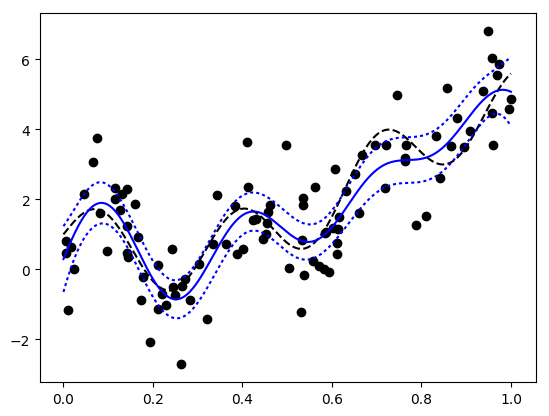

In [4]:
gp = GP(x_train, y_train, MeanZero(), SE(-2.0, 1.0), 0.0)

yhat_mean, yhat_var = predict(gp, grid)

plot(grid, true_y, color = "black", linestyle = "--")
scatter(x_train, y_train, color = "black")
plot(grid, yhat_mean, color = "blue")
plot(grid, yhat_mean + 2 * sqrt(yhat_var), color = "blue", linestyle = ":")
plot(grid, yhat_mean - 2 * sqrt(yhat_var), color = "blue", linestyle = ":");

## Gaussian Processes for Global Optimization

Fitting a model to the unknown function is great; but what the engineers really want is to optimize the function. That is, they want to find $\arg\min f(x)$. We should be able to use our model of the function to more efficiently optimize this function than applying usual optimization techniques.

For a simple case; given our model we need to determine the minimizer of our learned function. This is fairly straightforward. We simply introduce the loss function

$$L(x_{*}) = f(x)$$ 

and minimize its expectation

$$ E[L(x_{*})] = K(x_{*}, X)[K(X, X) + \sigma_{n}^{2}I]^{-1}y$$

which is equivalent to minimizing the mean function. This is usually a non-convex problem (like problem of minimizing the original function), but at least it's cheaper to evaluate.

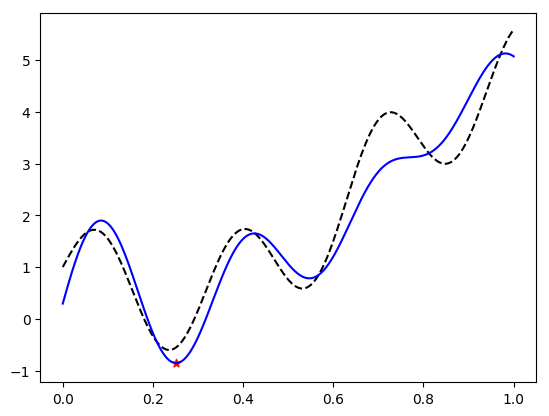

In [5]:
min_id = indmin(yhat_mean)
x_minimizer, y_min = grid[min_id], yhat_mean[min_id]

plot(grid, true_y, color = "black", linestyle = "--")
plot(grid, yhat_mean, color = "blue")
scatter(x_minimizer, y_min, marker = "*", color = "red");

In the more interesting case, we get to pick one more point to evaluate in order to find the best minimizer. For this we introduce the following loss function

$$ L(x_{*}) = \min(f(x_{*}), \nu) $$

where $\nu$ is the current minimum value.

Then the greedy solution selects $x^{*}$ to minimize the expectation of this loss function.

Finally, in fullest generality suppose we can add several points. Then we still minimize the expected loss, but it's a far more complicated integeral. Typically you can only look ahead a few points before it becomes cheaper to simply evaluate the function itself.

## Advantages and Drawbacks
+ O(n^3) complexity: although there are approximations available
+ Nonparametric: we can fit all sorts of functions
+ We only need to specify a covariance function: there's no reason why this has to be defined only on vectors. So we can do regression over strings, images, or any other sort of data as long as we can define a kernel.
+ We get an entire prediction distribution so we can make the appropriate decision theoretic choices
+ We can do classification too; logistic/probit regression generalizes although analytic posteriors no longer exist.
+ The derivative of a Gaussian process is another Gaussian process; so we can incorporate (noisy) derivative information if available.

## Application Areas
+ Hyperparameter Tuning
+ Bayesian Global Optimization
+ Numerics (Bayesian Quadrature)
+ Geostatistics (kriging)
+ Sensor placement
+ Dynamic systems
+ Emulators

## Resources
+ Literally the book on Gaussian Processes: http://www.gaussianprocess.org/gpml/chapters/
+ Papers
  + GPs for Global Optimization: http://www.robots.ox.ac.uk/~parg/pubs/OsborneGarnettRobertsGPGO.pdf
  + Sparse GPs using Pseudo-inputs: http://www.gatsby.ucl.ac.uk/~snelson/SPGP_up.pdf
  + Learning a Gaussian Process Prior for Automatically Generating Music Playlists: http://papers.nips.cc/paper/1996-learning-a-gaussian-process-prior-for-automatically-generating-music-playlists.pdf
  + Gaussian Process Approximations of Stochastic Differential Equations: http://jmlr.csail.mit.edu/proceedings/papers/v1/archambeau07a/archambeau07a.pdf
  + Learning to Control an Octopus Arm with Gaussian Process Temporal Difference Methods: http://papers.nips.cc/paper/2785-learning-to-control-an-octopus-arm-with-gaussian-process-temporal-difference-methods.pdf
+ Videos
  + Neil Lawrence at MLSS 2015: https://youtu.be/pmeAgona_to
  + Gaussian Processes for Big Data: https://youtu.be/wF2jtws2nFI
  + Modeling Complex Data with Deep Gaussian Processes: https://youtu.be/9CdfO_R2_lg
+ Software packages
  + Scikit-learn (python): http://scikit-learn.org/stable/modules/gaussian_process.html
  + GaussianProcesses.jl (Julia): https://github.com/STOR-i/GaussianProcesses.jl
  + gptk (R): https://cran.rproject.org/web/packages/gptk/gptk.pdf